In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
print(tf.__version__) # 2.3.0, gpu 2.2.0
import tensorflow_addons as tfa
# from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random

# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.0


Using TensorFlow backend.


Num GPUs Available:  1


In [2]:

# Lint as: python3
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Keras-based attention layer."""
# pylint: disable=g-classes-have-attributes
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import string

import numpy as np

from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.layers import advanced_activations
from tensorflow.python.keras.layers import core
from tensorflow.python.keras.layers import einsum_dense
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import special_math_ops
from tensorflow.python.util.tf_export import keras_export


_CHR_IDX = string.ascii_lowercase


def _build_attention_equation(rank, attn_axes):
  """Builds einsum equations for the attention computation.
  Query, key, value inputs after projection are expected to have the shape as:
  (bs, <non-attention dims>, <attention dims>, num_heads, channels).
  bs and <non-attention dims> are treated as <batch dims>.
  The attention operations can be generalized:
  (1) Query-key dot product:
  (<batch dims>, <query attention dims>, num_heads, channels), (<batch dims>,
  <key attention dims>, num_heads, channels) -> (<batch dims>,
  num_heads, <query attention dims>, <key attention dims>)
  (2) Combination:
  (<batch dims>, num_heads, <query attention dims>, <key attention dims>),
  (<batch dims>, <value attention dims>, num_heads, channels) -> (<batch dims>,
  <query attention dims>, num_heads, channels)
  Args:
    rank: the rank of query, key, value tensors.
    attn_axes: a list/tuple of axes, [-1, rank), that will do attention.
  Returns:
    Einsum equations.
  """
  target_notation = _CHR_IDX[:rank]
  # `batch_dims` includes the head dim.
  batch_dims = tuple(np.delete(range(rank), attn_axes + (rank - 1,)))
  letter_offset = rank
  source_notation = ""
  for i in range(rank):
    if i in batch_dims or i == rank - 1:
      source_notation += target_notation[i]
    else:
      source_notation += _CHR_IDX[letter_offset]
      letter_offset += 1

  product_notation = "".join([target_notation[i] for i in batch_dims] +
                             [target_notation[i] for i in attn_axes] +
                             [source_notation[i] for i in attn_axes])
  dot_product_equation = "%s,%s->%s" % (source_notation, target_notation,
                                        product_notation)
  attn_scores_rank = len(product_notation)
  combine_equation = "%s,%s->%s" % (product_notation, source_notation,
                                    target_notation)
  return dot_product_equation, combine_equation, attn_scores_rank


def _build_proj_equation(free_dims, bound_dims, output_dims):
  """Builds an einsum equation for projections inside multi-head attention."""
  input_str = ""
  kernel_str = ""
  output_str = ""
  bias_axes = ""
  letter_offset = 0
  for i in range(free_dims):
    char = _CHR_IDX[i + letter_offset]
    input_str += char
    output_str += char

  letter_offset += free_dims
  for i in range(bound_dims):
    char = _CHR_IDX[i + letter_offset]
    input_str += char
    kernel_str += char

  letter_offset += bound_dims
  for i in range(output_dims):
    char = _CHR_IDX[i + letter_offset]
    kernel_str += char
    output_str += char
    bias_axes += char
  equation = "%s,%s->%s" % (input_str, kernel_str, output_str)

  return equation, bias_axes, len(output_str)


def _get_output_shape(output_rank, known_last_dims):
  return [None] * (output_rank - len(known_last_dims)) + list(known_last_dims)


@keras_export("keras.layers.MultiHeadAttention")
class MultiHeadAttention(Layer):
  """MultiHeadAttention layer.
  This is an implementation of multi-headed attention based on "Attention
  is all you Need". If `query`, `key,` `value` are the same, then
  this is self-attention. Each timestep in `query` attends to the
  corresponding sequence in `key`, and returns a fixed-width vector.
  This layer first projects `query`, `key` and `value`. These are
  (effectively) a list of tensors of length `num_attention_heads`, where the
  corresponding shapes are [batch_size, <query dimensions>, key_dim],
  [batch_size, <key/value dimensions>, key_dim],
  [batch_size, <key/value dimensions>, value_dim].
  Then, the query and key tensors are dot-producted and scaled. These are
  softmaxed to obtain attention probabilities. The value tensors are then
  interpolated by these probabilities, then concatenated back to a single
  tensor.
  Finally, the result tensor with the last dimension as value_dim can take an
  linear projection and return.
  Examples:
  Performs 1D cross-attention over two sequence inputs with an attention mask.
  Returns the additional attention weights over heads.
  >>> layer = MultiHeadAttention(num_heads=2, key_dim=2)
  >>> target = tf.keras.Input(shape=[8, 16])
  >>> source = tf.keras.Input(shape=[4, 16])
  >>> output_tensor, weights = layer(target, source,
  ...                                return_attention_scores=True)
  >>> print(output_tensor.shape)
  (None, 8, 16)
  >>> print(weights.shape)
  (None, 2, 8, 4)
  Performs 2D self-attention over a 5D input tensor on axes 2 and 3.
  >>> layer = MultiHeadAttention(num_heads=2, key_dim=2, attention_axes=(2, 3))
  >>> input_tensor = tf.keras.Input(shape=[5, 3, 4, 16])
  >>> output_tensor = layer(input_tensor, input_tensor)
  >>> print(output_tensor.shape)
  (None, 5, 3, 4, 16)
  Arguments:
    num_heads: Number of attention heads.
    key_dim: Size of each attention head for query and key.
    value_dim:  Size of each attention head for value.
    dropout: Dropout probability.
    use_bias: Boolean, whether the dense layers use bias vectors/matrices.
    output_shape: The expected shape of an output tensor, besides the batch and
      sequence dims. If not specified, projects back to the key feature dim.
    attention_axes: axes over which the attention is applied. `None` means
      attention over all axes, but batch, heads, and features.
    kernel_initializer: Initializer for dense layer kernels.
    bias_initializer: Initializer for dense layer biases.
    kernel_regularizer: Regularizer for dense layer kernels.
    bias_regularizer: Regularizer for dense layer biases.
    activity_regularizer: Regularizer for dense layer activity.
    kernel_constraint: Constraint for dense layer kernels.
    bias_constraint: Constraint for dense layer kernels.
  Call arguments:
    query: Query `Tensor` of shape `[B, T, dim]`.
    value: Value `Tensor` of shape `[B, S, dim]`.
    key: Optional key `Tensor` of shape `[B, S, dim]`. If not given, will use
      `value` for both `key` and `value`, which is the most common case.
    attention_mask: a boolean mask of shape `[B, T, S]`, that prevents
      attention to certain positions.
    return_attention_scores: A boolean to indicate whether the output should
      be attention output if True, or (attention_output, attention_scores) if
      False. Defaults to False.
    training: Python boolean indicating whether the layer should behave in
      training mode (adding dropout) or in inference mode (no dropout).
      Defaults to either using the training mode of the parent layer/model,
      or False (inference) if there is no parent layer.
  Returns:
    attention_output: The result of the computation, of shape [B, T, E],
      where `T` is for target sequence shapes and `E` is the query input last
      dimension if `output_shape` is `None`. Otherwise, the multi-head outputs
      are project to the shape specified by `output_shape`.
    attention_scores: [Optional] multi-head attention coeffients over
      attention axes.
  """

  def __init__(self,
               num_heads,
               key_dim,
               value_dim=None,
               dropout=0.0,
               use_bias=True,
               output_shape=None,
               attention_axes=None,
               kernel_initializer="glorot_uniform",
               bias_initializer="zeros",
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(MultiHeadAttention, self).__init__(**kwargs)
    self._num_heads = num_heads
    self._key_dim = key_dim
    self._value_dim = value_dim if value_dim else key_dim
    self._dropout = dropout
    self._use_bias = use_bias
    self._output_shape = output_shape
    self._kernel_initializer = initializers.get(kernel_initializer)
    self._bias_initializer = initializers.get(bias_initializer)
    self._kernel_regularizer = regularizers.get(kernel_regularizer)
    self._bias_regularizer = regularizers.get(bias_regularizer)
    self._kernel_constraint = constraints.get(kernel_constraint)
    self._bias_constraint = constraints.get(bias_constraint)
    if attention_axes is not None and not isinstance(attention_axes,
                                                     collections.abc.Sized):
      self._attention_axes = (attention_axes,)
    else:
      self._attention_axes = attention_axes
    self._built_from_signature = False

  def get_config(self):
    config = {
        "num_heads":
            self._num_heads,
        "key_dim":
            self._key_dim,
        "value_dim":
            self._value_dim,
        "dropout":
            self._dropout,
        "use_bias":
            self._use_bias,
        "output_shape":
            self._output_shape,
        "attention_axes":
            self._attention_axes,
        "kernel_initializer":
            initializers.serialize(self._kernel_initializer),
        "bias_initializer":
            initializers.serialize(self._bias_initializer),
        "kernel_regularizer":
            regularizers.serialize(self._kernel_regularizer),
        "bias_regularizer":
            regularizers.serialize(self._bias_regularizer),
        "activity_regularizer":
            regularizers.serialize(self._activity_regularizer),
        "kernel_constraint":
            constraints.serialize(self._kernel_constraint),
        "bias_constraint":
            constraints.serialize(self._bias_constraint)
    }
    base_config = super(MultiHeadAttention, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def _build_from_signature(self, query, value, key=None):
    """Builds layers and variables.
    Once the method is called, self._built_from_signature will be set to True.
    Args:
      query: query tensor or TensorShape.
      value: value tensor or TensorShape.
      key: key tensor or TensorShape.
    """
    self._built_from_signature = True
    if hasattr(query, "shape"):
      query_shape = tensor_shape.TensorShape(query.shape)
    else:
      query_shape = query
    if hasattr(value, "shape"):
      value_shape = tensor_shape.TensorShape(value.shape)
    else:
      value_shape = value
    if key is None:
      key_shape = value_shape
    elif hasattr(key, "shape"):
      key_shape = tensor_shape.TensorShape(key.shape)
    else:
      key_shape = key

    common_kwargs = dict(
        kernel_initializer=self._kernel_initializer,
        bias_initializer=self._bias_initializer,
        kernel_regularizer=self._kernel_regularizer,
        bias_regularizer=self._bias_regularizer,
        activity_regularizer=self._activity_regularizer,
        kernel_constraint=self._kernel_constraint,
        bias_constraint=self._bias_constraint)
    # Any setup work performed only once should happen in an `init_scope`
    # to avoid creating symbolic Tensors that will later pollute any eager
    # operations.
    with tf_utils.maybe_init_scope(self):
      free_dims = query_shape.rank - 1
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          free_dims, bound_dims=1, output_dims=2)
      self._query_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._key_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="query",
          **common_kwargs)
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          key_shape.rank - 1, bound_dims=1, output_dims=2)
      self._key_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._key_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="key",
          **common_kwargs)
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          value_shape.rank - 1, bound_dims=1, output_dims=2)
      self._value_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._value_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="value",
          **common_kwargs)

      # Builds the attention computations for multi-head dot product attention.
      # These computations could be wrapped into the keras attention layer once
      # it support mult-head einsum computations.
      self._build_attention(output_rank)
      if self._output_shape:
        if not isinstance(self._output_shape, collections.abc.Sized):
          output_shape = [self._output_shape]
        else:
          output_shape = self._output_shape
      else:
        output_shape = [query_shape[-1]]
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          free_dims, bound_dims=2, output_dims=len(output_shape))
      self._output_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1, output_shape),
          bias_axes=bias_axes if self._use_bias else None,
          name="attention_output",
          **common_kwargs)

  def _build_attention(self, rank):
    """Builds multi-head dot-product attention computations.
    This function builds attributes necessary for `_compute_attention` to
    costomize attention computation to replace the default dot-product
    attention.
    Args:
      rank: the rank of query, key, value tensors.
    """
    if self._attention_axes is None:
      self._attention_axes = tuple(range(1, rank - 2))
    else:
      self._attention_axes = tuple(self._attention_axes)
    self._dot_product_equation, self._combine_equation, attn_scores_rank = (
        _build_attention_equation(rank, attn_axes=self._attention_axes))
    norm_axes = tuple(
        range(attn_scores_rank - len(self._attention_axes), attn_scores_rank))
    self._softmax = advanced_activations.Softmax(axis=norm_axes)
    self._dropout_layer = core.Dropout(rate=self._dropout)

  def _masked_softmax(self, attention_scores, attention_mask=None):
    # Normalize the attention scores to probabilities.
    # `attention_scores` = [B, N, T, S]
    if attention_mask is not None:
      # The expand dim happens starting from the `num_heads` dimension,
      # (<batch_dims>, num_heads, <query_attention_dims, key_attention_dims>)
      mask_expansion_axes = [-len(self._attention_axes) * 2 - 1]
      for _ in range(len(attention_scores.shape) - len(attention_mask.shape)):
        attention_mask = array_ops.expand_dims(
            attention_mask, axis=mask_expansion_axes)
    return self._softmax(attention_scores, attention_mask)

  def _compute_attention(self,
                         query,
                         key,
                         value,
                         attention_mask=None,
                         training=None):
    """Applies Dot-product attention with query, key, value tensors.
    This function defines the computation inside `call` with projected
    multi-head Q, K, V inputs. Users can override this function for customized
    attention implementation.
    Args:
      query: Projected query `Tensor` of shape `[B, T, N, key_dim]`.
      key: Projected key `Tensor` of shape `[B, T, N, key_dim]`.
      value: Projected value `Tensor` of shape `[B, T, N, value_dim]`.
      attention_mask: a boolean mask of shape `[B, T, S]`, that prevents
        attention to certain positions.
      training: Python boolean indicating whether the layer should behave in
        training mode (adding dropout) or in inference mode (doing nothing).
    Returns:
      attention_output: Multi-headed outputs of attention computation.
      attention_scores: Multi-headed attention weights.
    """
    # Note: Applying scalar multiply at the smaller end of einsum improves
    # XLA performance, but may introduce slight numeric differences in
    # the Transformer attention head.
    query = math_ops.multiply(query, 1.0 / math.sqrt(float(self._key_dim)))

    # Take the dot product between "query" and "key" to get the raw
    # attention scores.
    attention_scores = special_math_ops.einsum(self._dot_product_equation, key,
                                               query)

    attention_scores = self._masked_softmax(attention_scores, attention_mask)

    # This is actually dropping out entire tokens to attend to, which might
    # seem a bit unusual, but is taken from the original Transformer paper.
    attention_scores_dropout = self._dropout_layer(
        attention_scores, training=training)

    # `context_layer` = [B, T, N, H]
    attention_output = special_math_ops.einsum(self._combine_equation,
                                               attention_scores_dropout, value)
    return attention_output, attention_scores

  def call(self,
           query,
           value,
           key=None,
           attention_mask=None,
           return_attention_scores=False,
           training=None):
    if not self._built_from_signature:
      self._build_from_signature(query=query, value=value, key=key)
    if key is None:
      key = value

    #   N = `num_attention_heads`
    #   H = `size_per_head`
    # `query` = [B, T, N ,H]
    query = self._query_dense(query)

    # `key` = [B, S, N, H]
    key = self._key_dense(key)

    # `value` = [B, S, N, H]
    value = self._value_dense(value)

    attention_output, attention_scores = self._compute_attention(
        query, key, value, attention_mask, training)
    attention_output = self._output_dense(attention_output)

    if return_attention_scores:
      return attention_output, attention_scores
    return attention_output

In [3]:
# %pip install tensorflow==2.4.1
# %pip install tensorflow-gpu==2.3.0

In [4]:
# !echo $LD_LIBRARY_PATH

In [5]:
# !ls '/mnt/HDD01/rspl-admin/Trigger Journal/switch-cuda-master/'

In [6]:
# os.environ

In [7]:
!nvcc --version
# nvcc: NVIDIA (R) Cuda compiler driver
# Copyright (c) 2005-2017 NVIDIA Corporation
# Built on Fri_Nov__3_21:07:56_CDT_2017
# Cuda compilation tools, release 9.1, V9.1.85

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Nov__3_21:07:56_CDT_2017
Cuda compilation tools, release 9.1, V9.1.85


## Load Data

In [8]:
filename = 'Datasets/All_subjects_RDmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train1 = np.array(data["train_img"])
y_train1 = np.array(data["train_labels"])
x_test1 = np.array(data["test_img"])
y_test1 = np.array(data["test_labels"])
data.close()
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

Selected File: Datasets/All_subjects_RDmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [9]:
filename = 'Datasets/All_subjects_RAmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train2 = np.array(data["train_img"])
y_train2 = np.array(data["train_labels"])
x_test2 = np.array(data["test_img"])
y_test2 = np.array(data["test_labels"])
data.close()
print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

Selected File: Datasets/All_subjects_RAmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [10]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(x_train1[:,interval,:,:,:], (x_train1.shape[0],120,5,x_train1.shape[2],x_train1.shape[3],x_train1.shape[4]))
x_test11 = np.reshape(x_test1[:,interval,:,:,:], (x_test1.shape[0],120,5,x_test1.shape[2],x_test1.shape[3],x_test1.shape[4]))
y_train11 = np.reshape(np.argmax(y_train1[:,interval,:],-1), (y_train1.shape[0],120,5))
y_test11 = np.reshape(np.argmax(y_test1[:,interval,:],-1), (y_test1.shape[0],120,5))
y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
print(y_train11.shape)
print(x_test11.shape)
print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(x_train2[:,interval,:,:,:], (x_train2.shape[0],120,5,x_train2.shape[2],x_train2.shape[3],x_train2.shape[4]))
x_test12 = np.reshape(x_test2[:,interval,:,:,:], (x_test2.shape[0],120,5,x_test2.shape[2],x_test2.shape[3],x_test2.shape[4]))
y_train12 = np.reshape(np.argmax(y_train2[:,interval,:],-1), (y_train2.shape[0],120,5))
y_test12 = np.reshape(np.argmax(y_test2[:,interval,:],-1), (y_test2.shape[0],120,5))
y_train12 = to_categorical(np.squeeze(stats.mode(y_train12,2)[0]))
y_test12 = to_categorical(np.squeeze(stats.mode(y_test12,2)[0]))
print(x_train12.shape)
print(y_train12.shape)
print(x_test12.shape)
print(y_test12.shape) 

(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)
(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)


In [11]:
filename = 'Datasets/All_subjects_spectrogram.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train3 = np.array(data["train_img"])
y_train3 = np.array(data["train_labels"])
x_test3 = np.array(data["test_img"])
y_test3 = np.array(data["test_labels"])
data.close()
print(x_train3.shape)
print(y_train3.shape)
print(x_test3.shape)
print(y_test3.shape)

Selected File: Datasets/All_subjects_spectrogram.hdf5
(527, 120, 128, 128, 3)
(527, 120, 19)
(132, 120, 128, 128, 3)
(132, 120, 19)


In [12]:
filename = 'Datasets/All_subjects_margins_and_ctc_label_no_nucleus.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
margin_tr = np.array(data["train_img"])
ctc_tr = np.squeeze(np.array(data["train_labels"])).astype('U12')
margin_ts = np.array(data["test_img"])
ctc_ts = np.squeeze(np.array(data["test_labels"])).astype('U12')
data.close()
print(margin_tr.shape)
print(ctc_tr.shape)
print(margin_ts.shape)
print(ctc_ts.shape)

Selected File: Datasets/All_subjects_margins_and_ctc_label_no_nucleus.hdf5
(527, 1482)
(527,)
(132, 1482)
(132,)


In [13]:
filename = 'Datasets/All_subjects_spect_single.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train4 = np.array(data["train_img"])
x_test4 = np.array(data["test_img"])
data.close()
print(x_train4.shape)
print(x_test4.shape)

Selected File: Datasets/All_subjects_spect_single.hdf5
(527, 128, 128, 3)
(132, 128, 128, 3)


##### STA LTA

In [14]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

In [15]:
duration = 24.2
nsta_sec = 0.7
ratio = margin_tr.shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,margin_ts.shape[1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(margin_tr)):
    vecs_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(margin_ts)):
    vecs_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)

In [16]:
# downsample the mask to vid
mask_vid_tr = np.zeros(np.argmax(y_train1,-1).shape)
ratio1 = mask_train.shape[-1]/mask_vid_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_vid_tr[i,int(j/ratio1)] = 1
mask_vid_ts = np.zeros(np.argmax(y_test1,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_vid_ts[i,int(j/ratio1)] = 1

# downsample the mask to spect
mask_spect_tr = np.zeros(np.argmax(y_train3,-1).shape)
ratio2 = mask_train.shape[-1]/mask_spect_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_spect_tr[i,int(j/ratio2)] = 1
mask_spect_ts = np.zeros(np.argmax(y_test3,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_spect_ts[i,int(j/ratio2)] = 1
print('Mask shapes:')
print(mask_vid_tr.shape)
print(mask_vid_ts.shape)
print(mask_spect_tr.shape)
print(mask_spect_ts.shape)

Mask shapes:
(527, 605)
(132, 605)
(527, 120)
(132, 120)


In [17]:
def gesture_counter(mask):
    cnt = 0
    flag = 0
    for i in range(len(mask)):
        if flag == 0 and mask[i] == 0:
            continue
        if flag == 1 and mask[i] == 1:
            continue
        if flag == 0 and mask[i] == 1:
            flag = 1
            cnt += 1
        if flag == 1 and mask[i] == 0:
            flag = 0
    return cnt

In [18]:
numgest = [gesture_counter(m) for m in mask_spect_ts]
sum(numgest)

813

In [19]:
num_class = y_test3.shape[2]
num_class

19

In [20]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [21]:
x1train, y1train = masker(x_train11, y_train3, mask_spect_tr)
x1test, y1test = masker(x_test11, y_test3, mask_spect_ts)
x2train, y2train = masker(x_train12, y_train3, mask_spect_tr)
x2test, y2test = masker(x_test12, y_test3, mask_spect_ts)
x3train, y3train = masker(x_train3, y_train3, mask_spect_tr)
x3test, y3test = masker(x_test3, y_test3, mask_spect_ts)
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(y2train.shape)
print(x2test.shape)
print(y2test.shape)
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

/home/m/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(3042,)
(3042,)
(740,)
(740,)
(3042,)
(3042,)
(740,)
(740,)
(3042,)
(3042,)
(740,)
(740,)


In [22]:
y_int_train = np.array([np.argmax(y,-1) for y in y3train])
y_int_test = np.array([np.argmax(y,-1) for y in y3test])
print(y_int_train.shape)

(3042,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


### Multi-task labels

In [23]:
y_asldaily_tr = [] # 0: daily, 1: asl
y_twohanded_tr = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_tr = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_tr = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_tr = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

y_asldaily_ts = [] # 0: daily, 1: asl
y_twohanded_ts = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_ts = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_ts = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_ts = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

## asl daily
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_tr.append(to_categorical(yx,2))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_ts.append(to_categorical(yx,2))
    
## two hand
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_tr.append(to_categorical(yx,3))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_ts.append(to_categorical(yx,3))

## hand loc
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] == 4:
            yx[j] = 1
        elif y_int_train[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_train[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_tr.append(to_categorical(yx,5))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] == 4:
            yx[j] = 1
        elif y_int_test[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_test[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_ts.append(to_categorical(yx,5))

## movement type
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_train[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_train[i][j] == 13:
            yx[j] = 3
        elif y_int_train[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_tr.append(to_categorical(yx,6))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_test[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_test[i][j] == 13:
            yx[j] = 3
        elif y_int_test[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_ts.append(to_categorical(yx,6))
    
## # of strokes
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_train[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_tr.append(to_categorical(yx,4))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_test[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_ts.append(to_categorical(yx,4))

### CTC labels

In [24]:
def num_to_ch(num):
    label = ''
    for ch in num:
        label += chr(ord('@') + np.argmax(ch,-1)+1)
    return label

In [25]:
# convert detected labels
ctc_tr3 = [num_to_ch(y) for y in y3train]
ctc_ts3 = [num_to_ch(y) for y in y3test]

In [26]:
characters3 = set(char for label in ctc_tr3 for char in label)
print("Number of unique characters: ", len(characters3))
print("Characters present: ", sorted(characters3))
# print('Labels: ' + str(np.unique(ctc_tr3)))
batch_size = 1

Number of unique characters:  19
Characters present:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S']


In [27]:
input_shape = (None,x3train[0].shape[1],x3train[0].shape[2],x3train[0].shape[3])
input_shape

(None, 128, 128, 3)

In [28]:
input_shape_vid = (None, x1train[0].shape[1], x1train[0].shape[2], x1train[0].shape[3], x1train[0].shape[4])
input_shape_vid

(None, 5, 128, 128, 3)

In [29]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [30]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

In [31]:
def data_generator_multi_uncert(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3, y_train, y_train2, y_train3, y_train4, y_train5, y_train6], np.concatenate([y_train2, y_train3, y_train4, y_train5, y_train6],-1)
            
#             [y_train2, y_train3, y_train4, y_train5, y_train6]

In [32]:
def data_generator_multi_uncert_nolabel(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [33]:
from keras import backend as K
class CustomMultiLossLayer_ctc(Layer):
    def __init__(self, nb_outputs=6, **kwargs):
        self.nb_outputs = nb_outputs
        self.is_placeholder = True
        super(CustomMultiLossLayer_ctc, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=keras.initializers.Constant(0.), trainable=True)]
        super(CustomMultiLossLayer_ctc, self).build(input_shape)

    def multi_loss(self, ys_true, ys_pred):
#         print('ystrue: '+str(len(ys_true)))
#         print('nb_outputs: '+str(self.nb_outputs))
#         print('yspred: '+str(len(ys_pred)))
        
        assert len(ys_true) == self.nb_outputs and len(ys_pred) == self.nb_outputs
        loss = 0
        ctc_loss_fn = keras.backend.ctc_batch_cost
        cnt = 0
        for y_true, y_pred, log_var in zip(ys_true, ys_pred, self.log_vars):
#             print(K.int_shape(y_true))
#             print(K.int_shape(y_pred))
#             assert y_true.shape == y_pred.shape, 'shapes not match'
            if cnt > 0: # if auxilary
                precision = K.exp(-log_var[0])
                loss += K.sum(precision * (y_true - y_pred)**2. + log_var[0], -1)
#                 print('aux: ' + str(cnt))
            if cnt == 0: # if ctc labels
#                 y_true = tf.expand_dims(y_true,0)
#                 y_pred = tf.expand_dims(y_pred,0)
                batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
#                 print('ctc: ' + str(cnt))
                input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
                label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
                input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
                label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
                loss += ctc_loss_fn(y_true, y_pred, input_length, label_length)
            cnt += 1
        return K.mean(loss)

    def call(self, inputs):
        ys_true = inputs[:self.nb_outputs]
        ys_pred = inputs[self.nb_outputs:]
        loss = self.multi_loss(ys_true, ys_pred)
        self.add_loss(loss, inputs=inputs)
#         for i in range(len(inputs)):
#             print(inputs[i].get_shape())
#         del inputs[6]
#         del inputs[0]
        trues = K.concatenate(inputs[1:6], -1)
        preds = K.concatenate(inputs[7:], -1)
#         cat_out = K.concatenate([trues,preds], -1)
#         print(cat_out.shape)
        return preds
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'nb_outputs': self.nb_outputs,
            'is_placeholder': self.is_placeholder,
            'log_vars': self.log_vars,
            'add_weight': self.add_weight,
            'add_loss': self.add_loss,
        })
        return config

In [34]:
class Attention(Layer):
    
    def __init__(self,  return_sequences=True):
        self.return_sequences = return_sequences
#         self.length = length
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
#         self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
#                                initializer="normal")
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],None),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=None,
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [35]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [36]:
maxlen = 0
maxlen = [y.shape[0] for y in y3train if y.shape[0]>maxlen]
maxlen2 = max(maxlen)
maxlen2

43

In [37]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(maxlen2,1),initializer="zeros"),        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [38]:
def ctc__multi_att():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="rd")
        inputlayer2 = Input(shape = input_shape_vid, name="ra")
        inputlayer3 = Input(shape = input_shape, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        asl = Input(name="asl_in", shape=(None,2))#, dtype="float32")
        hand = Input(name="hand_in", shape=(None,3))#, dtype="float32")
        loc = Input(name="loc_in", shape=(None,5))#, dtype="float32")
        mov = Input(name="mov_in", shape=(None,6))#, dtype="float32")
        stroke = Input(name="str_in", shape=(None,4))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
        new_shape = (-1, (128//2**3) *64 *5 )
        cnv1 = Reshape(target_shape=new_shape, name="reshape")(x)
        cnv1 = Dense(64, activation="relu", name="dense1")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
        
        y = TimeDistributed(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))(inputlayer2)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(y)
        new_shape2 = (-1, (128//2**3) *64 *5 )
        cnv2 = Reshape(target_shape=new_shape2, name="reshape2")(y)
        cnv2 = Dense(64, activation="relu", name="dense3")(cnv2)
        cnv2 = Dropout(0.5)(cnv2)
        cnv2 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv2)
        
        z = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer3)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(z)
        new_shape3 = (-1, (128//2**3) *64 )
        cnv3 = Reshape(target_shape=new_shape3, name="reshape3")(z)
        cnv3 = Dense(64, activation="relu", name="dense4")(cnv3)
        cnv3 = Dropout(0.5)(cnv3)
        cnv3 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv3)
    
        concat = concatenate([cnv1,cnv2,cnv3], name = 'concatlayer')
#         concat = K.print_tensor(concat, message = 'concatprint') # [tf.shape(out_asldaily)]
        aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(concat)
        
#         att_asldaily = Attention(return_sequences=True)(aux_pool)
#         embed_dim = 32  # Embedding size for each token
#         num_heads = [2, 3, 5, 6, 4]  # Number of attention heads
#         ff_dim = 32  # Hidden layer size in feed forward network inside transformer
        
#         att_asldaily = TransformerBlock(embed_dim, num_heads[0], ff_dim)
        
#         aux_pool = Flatten(-1,128*3)(aux_pool)
#         print(aux_pool.get_shape[1])
#         att_asldaily2 = TimeDistributed(att_asldaily(aux_pool))
        
        att_asldaily = Attention(return_sequences = True)(aux_pool)
        att_twohanded = Attention(return_sequences = True)(aux_pool)
        att_major = Attention(return_sequences = True)(aux_pool)
        att_movement = Attention(return_sequences = True)(aux_pool)
        att_stroke = Attention(return_sequences = True)(aux_pool)
        
        out_asldaily = TimeDistributed(Dense(2, activation='sigmoid'), name="asldaily")(att_asldaily)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(att_twohanded)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(att_major)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(att_movement)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(att_stroke)
        print(out_asldaily.get_shape)
#         out_asldaily = K.print_tensor(out_asldaily, message = 'asloutx') # [tf.shape(out_asldaily)]
#         out_twohanded = K.print_tensor(out_twohanded, message = 'out_twohanded') # [tf.shape(out_asldaily)]
#         out_major = K.print_tensor(out_major, message = 'out_major') # [tf.shape(out_asldaily)]
#         out_movement = K.print_tensor(out_movement, message = 'out_movement') # [tf.shape(out_asldaily)]
#         out_stroke = K.print_tensor(out_stroke, message = 'out_stroke') # [tf.shape(out_asldaily)]
        
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(concat)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        out = CustomMultiLossLayer_ctc(nb_outputs = 6)([labels, asl, hand, loc, mov, stroke,
#                                                      asl, hand, loc, mov, stroke])
                                                   x2, out_asldaily, out_twohanded,
                                                   out_major, out_movement, out_stroke])
        
        model = keras.Model(inputs = [inputlayer, inputlayer2, inputlayer3, 
                            labels, asl, hand, loc, mov, stroke], 
                            outputs = out, 
                           name="ctc_model")
#         model = keras.Model([inputlayer, inputlayer2, inputlayer3, labels,
#                             ], out)
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
#         model.compile(optimizer=opt,  loss = losses, loss_weights = lossWeights)#, metrics = metrics)
        
        model.compile(optimizer=opt, run_eagerly=False, loss = None)
        
        return model

In [40]:
model_att = ctc__multi_att()

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [189]:
tf.get_logger().setLevel('ERROR')

In [190]:
train_dataset = data_generator_multi_uncert([x1train, x2train, x3train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_uncert([x1test, x2test, x3test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_uncert_nolabel([x1test, x2test, x3test])

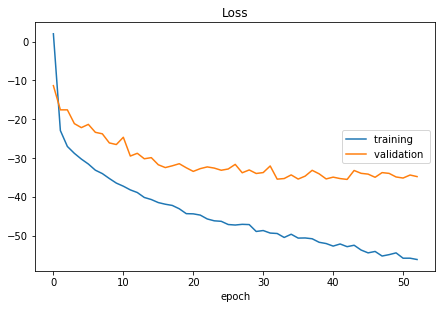

Loss
	training         	 (min:  -56.181, max:    2.042, cur:  -56.181)
	validation       	 (min:  -35.522, max:  -11.334, cur:  -34.794)
3042/3042 [==============================] - 358s 118ms/step - loss: -56.1805 - val_loss: -34.7938


In [191]:
history = model_att.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [192]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model_att.get_layer(name="rd").input, model_att.get_layer(name="ra").input, 
    model_att.get_layer(name="image").input], model_att.get_layer(name="dense2").output
)
# prediction_model = keras.models.Model(
#     model_multi.inputs, model_multi.get_layer(name="dense2").output
# )
# prediction_model.summary()

In [193]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [194]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

CCCCCCCCCCCCCAA


In [195]:
for idx in range(len(ctc_ts3)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: AAAAAABBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | AAABBBBBBBBBBBBBBBBB :Original
2. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBB | BBBBBBBBBBBBB :Original
3. Predicted: CCCCCCCCCCCCCAA | ACCCCCCCCAA :Original
4. Predicted: NNNNNNNNNNNNNNNNNNNNNNA | NNNNNNNNNN :Original
5. Predicted: AAAAAAAAAAAAAAAOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOAAAAAAA | AAAAAOOOOOOOOOOOOOAA :Original
6. Predicted: AAAAAPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAA | AAPPPPPPPPPPPPPA :Original
7. Predicted: AAAAAAADDDDDDDDDDDDDDDDDDDDDDDDDDDDD | AAADDDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBBBBBBBBBB | BBBBBBBCCCCCCC :Original
9. Predicted: AAANNNNNNNNNNAAAAA | AAANNNNNNNNAA :Original
10. Predicted: AAAAAAAAAAAAAA | AAAOOOOOOOOOOOOOAA :Original
11. Predicted: AAAAPPPPPPPPPPPPPPPPPPPPPPPPPPPPP | APPPPPPPPPPPPPPPA :Original
12. Predicted: AADDDDDDDDDDD | ADDDDDDDDAA :Original
13. Predicted: AAAAABBBBBBBBBBBBBBBBBBBBBBBBBBBBB | AABBBBBBBBBBBBBBBB :Original
14. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | BBBBBBBBB

In [196]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [197]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

78.51351351351352

In [202]:
# save model
fname = 'att ctc aux multitask multi input uncert'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model_att.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model_att.save_weights(WEIGHT_FILE)

In [203]:
model_att.summary()

Model: "ctc_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rd (InputLayer)                 [(None, None, 5, 128 0                                            
__________________________________________________________________________________________________
ra (InputLayer)                 [(None, None, 5, 128 0                                            
__________________________________________________________________________________________________
image (InputLayer)              [(None, None, 128, 1 0                                            
__________________________________________________________________________________________________
time_distributed_1051 (TimeDist (None, None, 5, 128, 2624        rd[0][0]                         
__________________________________________________________________________________________

In [221]:
rd_asl = []
ra_asl = []
md_asl = []
l_names = ['attention_52','attention_53','attention_54','attention_55','attention_56']
for i in range(5): # num aux
    att = model_att.get_layer(l_names[i]).get_weights()
    rd_asl.append(sum(att[0][:128]))
    ra_asl.append(sum(att[0][128:256]))
    md_asl.append(sum(att[0][256:]))
rd_asl = np.array(rd_asl)
ra_asl = np.array(ra_asl)
md_asl = np.array(md_asl)
rd_asl.shape

(5, 1)

In [225]:
sumvector = rd_asl+ra_asl+md_asl
minvector = np.array([min(rd_asl[i],ra_asl[i],md_asl[i]) for i in range(5)])
# minvector

In [230]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

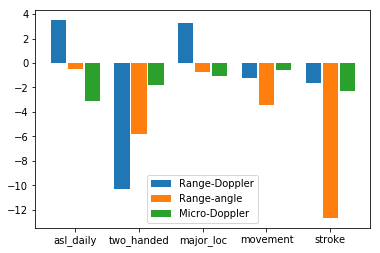

In [238]:
data = {
        "Range-Doppler": rd_asl,
        "Range-angle": ra_asl,
        "Micro-Doppler": md_asl
    }

fig, ax = plt.subplots()
bar_plot(ax, data, total_width=.8, single_width=.9)
plt.xticks(range(5), ["asl_daily", "two_handed", "major_loc", "movement", "stroke"])
plt.savefig('weights.png')

## Attention v2

In [240]:
def ctc__multi_att_v2():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="rd")
        inputlayer2 = Input(shape = input_shape_vid, name="ra")
        inputlayer3 = Input(shape = input_shape, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        asl = Input(name="asl_in", shape=(None,2))#, dtype="float32")
        hand = Input(name="hand_in", shape=(None,3))#, dtype="float32")
        loc = Input(name="loc_in", shape=(None,5))#, dtype="float32")
        mov = Input(name="mov_in", shape=(None,6))#, dtype="float32")
        stroke = Input(name="str_in", shape=(None,4))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
        new_shape = (-1, (128//2**3) *64 *5 )
        cnv1 = Reshape(target_shape=new_shape, name="reshape")(x)
        cnv1 = Dense(64, activation="relu", name="dense1")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
        
        y = TimeDistributed(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))(inputlayer2)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(y)
        new_shape2 = (-1, (128//2**3) *64 *5 )
        cnv2 = Reshape(target_shape=new_shape2, name="reshape2")(y)
        cnv2 = Dense(64, activation="relu", name="dense3")(cnv2)
        cnv2 = Dropout(0.5)(cnv2)
        cnv2 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv2)
        
        z = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer3)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(z)
        new_shape3 = (-1, (128//2**3) *64 )
        cnv3 = Reshape(target_shape=new_shape3, name="reshape3")(z)
        cnv3 = Dense(64, activation="relu", name="dense4")(cnv3)
        cnv3 = Dropout(0.5)(cnv3)
        cnv3 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv3)
    
        concat = concatenate([cnv1,cnv2,cnv3], name = 'concatlayer')
#         concat = K.print_tensor(concat, message = 'concatprint') # [tf.shape(out_asldaily)]
        aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(concat)
        
#         att_asldaily = Attention(return_sequences=True)(aux_pool)
#         embed_dim = 32  # Embedding size for each token
#         num_heads = [2, 3, 5, 6, 4]  # Number of attention heads
#         ff_dim = 32  # Hidden layer size in feed forward network inside transformer
        
#         att_asldaily = TransformerBlock(embed_dim, num_heads[0], ff_dim)
        
#         aux_pool = Flatten(-1,128*3)(aux_pool)
#         print(aux_pool.get_shape[1])
#         att_asldaily2 = TimeDistributed(att_asldaily(aux_pool))
        
        att_asldaily = Attention(return_sequences = True)(aux_pool)
#         att_twohanded = Attention(return_sequences = True)(aux_pool)
#         att_major = Attention(return_sequences = True)(aux_pool)
#         att_movement = Attention(return_sequences = True)(aux_pool)
#         att_stroke = Attention(return_sequences = True)(aux_pool)
        
        out_asldaily = TimeDistributed(Dense(2, activation='sigmoid'), name="asldaily")(att_asldaily)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(att_asldaily)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(att_asldaily)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(att_asldaily)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(att_asldaily)
        print(out_asldaily.get_shape)
#         out_asldaily = K.print_tensor(out_asldaily, message = 'asloutx') # [tf.shape(out_asldaily)]
#         out_twohanded = K.print_tensor(out_twohanded, message = 'out_twohanded') # [tf.shape(out_asldaily)]
#         out_major = K.print_tensor(out_major, message = 'out_major') # [tf.shape(out_asldaily)]
#         out_movement = K.print_tensor(out_movement, message = 'out_movement') # [tf.shape(out_asldaily)]
#         out_stroke = K.print_tensor(out_stroke, message = 'out_stroke') # [tf.shape(out_asldaily)]
        
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(concat)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        out = CustomMultiLossLayer_ctc(nb_outputs = 6)([labels, asl, hand, loc, mov, stroke,
#                                                      asl, hand, loc, mov, stroke])
                                                   x2, out_asldaily, out_twohanded,
                                                   out_major, out_movement, out_stroke])
        
        model = keras.Model(inputs = [inputlayer, inputlayer2, inputlayer3, 
                            labels, asl, hand, loc, mov, stroke], 
                            outputs = out, 
                           name="ctc_model")
#         model = keras.Model([inputlayer, inputlayer2, inputlayer3, labels,
#                             ], out)
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
#         model.compile(optimizer=opt,  loss = losses, loss_weights = lossWeights)#, metrics = metrics)
        
        model.compile(optimizer=opt, run_eagerly=False, loss = None)
        
        return model

In [241]:
model_att2 = ctc__multi_att_v2()

<bound method Tensor.get_shape of <tf.Tensor 'asldaily/Reshape_19:0' shape=(None, None, 2) dtype=float32>>


In [242]:
tf.get_logger().setLevel('ERROR')

In [243]:
train_dataset = data_generator_multi_uncert([x1train, x2train, x3train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_uncert([x1test, x2test, x3test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_uncert_nolabel([x1test, x2test, x3test])

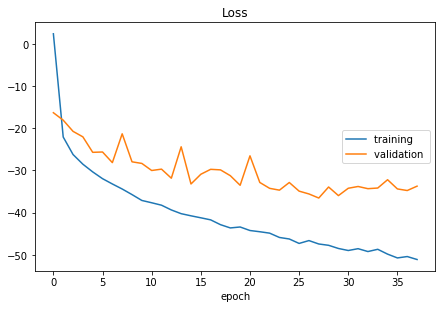

Loss
	training         	 (min:  -56.181, max:    2.393, cur:  -51.114)
	validation       	 (min:  -36.539, max:  -11.334, cur:  -33.726)
3042/3042 [==============================] - 358s 118ms/step - loss: -51.1142 - val_loss: -33.7261


In [244]:
history = model_att2.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [245]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model_att2.get_layer(name="rd").input, model_att2.get_layer(name="ra").input, 
    model_att2.get_layer(name="image").input], model_att2.get_layer(name="dense2").output
)
# prediction_model = keras.models.Model(
#     model_multi.inputs, model_multi.get_layer(name="dense2").output
# )
# prediction_model.summary()

In [246]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [247]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

CCCCCCCCCCCCCCCCCCCAAAA


In [248]:
for idx in range(len(ctc_ts3)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: AAAAAAAABBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | AAABBBBBBBBBBBBBBBBB :Original
2. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | BBBBBBBBBBBBB :Original
3. Predicted: CCCCCCCCCCCCCCCCCCCAAAA | ACCCCCCCCAA :Original
4. Predicted: ANNNNNNNNNNNNNNNNNNNAAA | NNNNNNNNNN :Original
5. Predicted: AAAAAAAAAAAAAAAAAAAAOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOAAAAAAA | AAAAAOOOOOOOOOOOOOAA :Original
6. Predicted: AAAAAAAAAPPPPPPPPPPPPPPPPPPPPPPPPPAAAAA | AAPPPPPPPPPPPPPA :Original
7. Predicted: AAAAAAADDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD | AAADDDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | BBBBBBBCCCCCCC :Original
9. Predicted: AAAAAAAAANNAAAAAAA | AAANNNNNNNNAA :Original
10. Predicted: AAAAAAAAAAMMAAAAAAAAAA | AAAOOOOOOOOOOOOOAA :Original
11. Predicted: AAAAAAPPPPPPPPPPPPPPPPPAAA | APPPPPPPPPPPPPPPA :Original
12. Predicted: DDDDDDDDDDDDDDDAAAA | ADDDDDDDDAA :Original
13. Predicted: AAAAABBBBBBBBBBBBBBBBBBBBBBBB | AABBBBBBBBBBBBBBBB :Origina

In [249]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [250]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

82.43243243243244

In [251]:
# save model
fname = 'att ctc aux multitask multi input uncert 2'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

# model_json = model_att.to_json()
# with open(MODEL_FILE, "w") as json_file:
#     json_file.write(model_json)
model_att2.save_weights(WEIGHT_FILE)

In [257]:
import pydot
import graphviz
keras.utils.plot_model(model_att)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
